In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
PATH = 'vnindex_preprocess.csv'

## Preprocessing

In [3]:
sp500 = pd.read_csv(PATH)

In [4]:
# Checking null
sp500.isnull().sum()

Unnamed: 0      0
time            0
open            0
high            0
low             0
close           0
MA              0
Histogram       0
MACD            0
Signal          0
RSI             0
RSI-based MA    0
dtype: int64

In [5]:
#  Checking nan
sp500.isna().sum()

Unnamed: 0      0
time            0
open            0
high            0
low             0
close           0
MA              0
Histogram       0
MACD            0
Signal          0
RSI             0
RSI-based MA    0
dtype: int64

In [6]:
#  Dropnan
sp500.dropna(inplace = True)
sp500.isna().any()

Unnamed: 0      False
time            False
open            False
high            False
low             False
close           False
MA              False
Histogram       False
MACD            False
Signal          False
RSI             False
RSI-based MA    False
dtype: bool

In [7]:
sp500['time'] = pd.to_datetime(sp500.time)

In [8]:
sp500.shape

(12185, 12)

### Data Exploration

In [9]:
print("Starting date: ",sp500.iloc[0][0])
print("Ending date: ", sp500.iloc[-1][0])
print("Duration: ", sp500.iloc[-1][0]-sp500.iloc[0][0])

Starting date:  0
Ending date:  12184
Duration:  12184


In [11]:
# sp500.to_csv('vnindex_preprocess.csv')

## Machine Learning

In [3]:
from utils.utils import create_data_train, read_csv
from configs.config import *
from utils.preprocess import Preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 

In [4]:
path = 'vnindex_preprocess.csv'
ts_config = TSConfig()
frame = read_csv(path, ts_config.train_features, ts_config.pred_features, return_np = True)
preprocess = Preprocessing()
ML = True

vnindex_preprocess.csv


In [5]:
feature = frame['feature']
target = frame['target']

In [6]:
target.shape

(12185, 2)

In [7]:
#   Scaling data
feature, (feature_max_scale, feature_min_scale) = preprocess.apply_minmax_scale(feature)

In [8]:
target, (target_max_scale, target_min_scale) = preprocess.apply_minmax_scale(target)

In [9]:
train_test_ratio = 0.8
seq_steps        = 7

In [10]:
X, Y = create_data_train(feature, target, seq_steps)
if ML:
    X = X.detach().cpu().numpy()
    Y = Y.detach().cpu().numpy()

In [11]:
split_idx = int(X.shape[0] * train_test_ratio)


In [12]:
#   Predict high
x_train, y_train = X[:split_idx, :, :], Y[:split_idx, :]
x_test, y_test   = X[split_idx:, :, :], Y[split_idx:, :]

print(y_train.shape, y_test.shape)

(9738, 2) (2435, 2)


In [13]:
print(f'Number of traning samples = {x_train.shape[0]}\nNumber of testing samples = {y_test.shape[0]}')
print(x_train.shape)

Number of traning samples = 9738
Number of testing samples = 2435
(9738, 7, 8)


In [14]:
def max_min_inverse(inp, max_scale, min_scale):
    print(max_scale)
    return (inp * (max_scale - min_scale)) + min_scale

In [15]:
#   Predict categories
"""
'high': 0
'low': 1
'MA:   2
'MACD': 3
'open': 4
'close': 5
'Volume': 6
'Volume MA': 7
'MA': 8
'Histogram': 9
'MACD': 10
'Signal': 11
"""
category = 1
x_train_ml = x_train[:, :, category]
x_test_ml = x_test[:, :, category]
y_train_ml = y_train[:, category]
y_test_ml  = y_test[:,category]

print(f'Feature selection = {ts_config.pred_features[category]}')
print(f'Train shape: {x_train_ml.shape}, {y_train_ml.shape}\nTest shape: {x_test_ml.shape}, {y_test_ml.shape}')

Feature selection = low
Train shape: (9738, 7), (9738,)
Test shape: (2435, 7), (2435,)


### Support Vector Regressor

In [23]:
from sklearn.svm import SVR
from configs.config import BASEDIR
import pickle

In [25]:
def evaluate_SVR(x_train, y_train, x_test, y_test, C, gamma, category):
    svr_rbf = SVR(kernel = 'rbf', C= 1e2, gamma= 0.1)
    svr_rbf.fit(x_train, y_train)

    train_predict=svr_rbf.predict(x_train)
    test_predict=svr_rbf.predict(x_test)

    y_test_rescale = max_min_inverse(y_test, target_max_scale[:, category], target_min_scale[:, category])
    pred_rescale   = max_min_inverse(test_predict, target_max_scale[:, category], target_min_scale[:, category])

    train_predict = train_predict.reshape(-1,1)
    test_predict = test_predict.reshape(-1,1)
    
    mean_sqr_err = mean_squared_error(y_test_rescale, pred_rescale)
    mean_abs_err = mean_absolute_error(y_test_rescale, pred_rescale)
    r_square     = r2_score(y_test_rescale, pred_rescale)
    print("Train data prediction:", train_predict.shape)
    print("Test data prediction:", test_predict.shape)
    print(f'Prediction of {ts_config.pred_features[category]}')
    print(f'MAE = {mean_abs_err}\nMSE = {mean_sqr_err}\nR square = {r_square}')

    results = {
        'prediction_' + ts_config.pred_features[category]: pred_rescale,
        'ground_truth': y_test_rescale,
        'MSE': mean_sqr_err,
        'MAE': mean_abs_err,
        'R2': r_square,
        'RMSE': np.sqrt(mean_sqr_err)
    }

    print(results)
    save_pkl_path = BASEDIR / f'save/SVR_{ts_config.pred_features[category]}.pkl'
    with open(save_pkl_path, mode=  'wb') as writer:
        pickle.dump(results, writer)
    writer.close()

In [26]:
evaluate_SVR(x_train_ml, y_train_ml, x_test_ml, y_test_ml, 1e2, 1e-1, category)

[1531.05]
[1531.05]
Train data prediction: (9738, 1)
Test data prediction: (2435, 1)
Prediction of low
MAE = 101.1662418540348
MSE = 14554.19819669112
R square = 0.489477272243352
{'prediction_low': array([1154.1755475 , 1154.36699335, 1154.05539727, ..., 1037.07704536,
       1036.42622005, 1035.38639672]), 'ground_truth': array([1222.35998326, 1229.3900312 , 1229.95000122, ..., 1061.70000528,
       1059.1100245 , 1052.89001852]), 'MSE': 14554.19819669112, 'MAE': 101.1662418540348, 'R2': 0.489477272243352, 'RMSE': 120.64078164821015}


### Random Forest

In [27]:
from sklearn.ensemble import RandomForestRegressor
import pickle

In [28]:
def evaluate_randomfr(x_train, y_train, x_test, y_test, C, gamma, category):


    regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
    regressor.fit(x_train, y_train)

    train_predict=regressor.predict(x_train)
    test_predict=regressor.predict(x_test)

    y_test_rescale = max_min_inverse(y_test, target_max_scale[:, category], target_min_scale[:, category])
    pred_rescale   = max_min_inverse(test_predict, target_max_scale[:, category], target_min_scale[:, category])

    train_predict = train_predict.reshape(-1,1)
    test_predict = test_predict.reshape(-1,1)
    
    mean_sqr_err = mean_squared_error(y_test_rescale, pred_rescale)
    mean_abs_err = mean_absolute_error(y_test_rescale, pred_rescale)
    r_square     = r2_score(y_test_rescale, pred_rescale)
    print("Train data prediction:", train_predict.shape)
    print("Test data prediction:", test_predict.shape)
    print(f'Prediction of {ts_config.pred_features[category]}')
    print(f'MAE = {mean_abs_err}\nMSE = {mean_sqr_err}\nR square = {r_square}')

    results = {
        'prediction_' + ts_config.pred_features[category]: pred_rescale,
        'ground_truth': y_test_rescale,
        'MSE': mean_sqr_err,
        'MAE': mean_abs_err,
        'R2': r_square,
        'RMSE': np.sqrt(mean_sqr_err)
    }

    print(results)
    save_pkl_path = BASEDIR / f'save/RandomF/rfr_{ts_config.pred_features[category]}.pkl'
    with open(save_pkl_path, mode=  'wb') as writer:
        pickle.dump(results, writer)
    writer.close()

In [29]:
evaluate_randomfr(x_train_ml, y_train_ml, x_test_ml, y_test_ml, 1e2, 1e-1, category)

[1531.05]
[1531.05]
Train data prediction: (9738, 1)
Test data prediction: (2435, 1)
Prediction of low
MAE = 77.82501387506404
MSE = 13944.290805341052
R square = 0.5108712082680633
{'prediction_low': array([1211.64589839, 1225.69169781, 1229.96290302, ..., 1058.69890623,
       1059.60930572, 1056.92840325]), 'ground_truth': array([1222.35998326, 1229.3900312 , 1229.95000122, ..., 1061.70000528,
       1059.1100245 , 1052.89001852]), 'MSE': 13944.290805341052, 'MAE': 77.82501387506404, 'R2': 0.5108712082680633, 'RMSE': 118.08594668859226}


### ARIMA

In [3]:
from statsmodels.tsa.arima_model import ARIMA

## Stacked LSTM

In [22]:
import tensorflow as tf 
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras import Sequential

In [23]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(16,return_sequences=True,input_shape=(ts_config.n_steps, ts_config.n_features)))
model.add(LSTM(16))
model.add(Dense(ts_config.n_classes))
model.compile(loss='mean_squared_error',optimizer='adam')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 16)             1600      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 2)                 34        
                                                                 
Total params: 3,746
Trainable params: 3,746
Non-trainable params: 0
_________________________________________________________________


In [22]:
x_train_dl = X[:split_idx, :, :]
y_train_dl = Y[:split_idx, :]
x_test_dl  = X[split_idx: , :, :]
y_test_dl  = Y[split_idx:, :]

print(f'Train samples: {x_train_dl.shape} -- Test samples: {x_test_dl.shape}')
print(f'Train targets: {y_train_dl.shape} -- Test targets: {y_test_dl.shape}')

Train samples: (9738, 7, 8) -- Test samples: (2435, 7, 8)
Train targets: (9738, 2) -- Test targets: (2435, 2)


In [26]:
model.fit(x_train_dl,y_train_dl,validation_data=(x_test_dl,y_test_dl),epochs=100,batch_size=512,verbose=1)
model.save(f'save/StackedLSTM/ckpt/lstm.h5')

Epoch 1/100
20/20 [==============================] - 3s 36ms/step - loss: 0.0561 - val_loss: 0.1732
Epoch 2/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0172 - val_loss: 0.0795
Epoch 3/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0055 - val_loss: 0.0211
Epoch 4/100
20/20 [==============================] - 0s 10ms/step - loss: 5.3456e-04 - val_loss: 0.0090
Epoch 5/100
20/20 [==============================] - 0s 10ms/step - loss: 3.0170e-04 - val_loss: 0.0083
Epoch 6/100
20/20 [==============================] - 0s 13ms/step - loss: 1.9673e-04 - val_loss: 0.0086
Epoch 7/100
20/20 [==============================] - 0s 10ms/step - loss: 1.6851e-04 - val_loss: 0.0077
Epoch 8/100
20/20 [==============================] - 0s 10ms/step - loss: 1.5729e-04 - val_loss: 0.0075
Epoch 9/100
20/20 [==============================] - 0s 16ms/step - loss: 1.5157e-04 - val_loss: 0.0070
Epoch 10/100
20/20 [==============================] - 0s 13ms/step - loss: 1

In [27]:
train_predict=model.predict(x_train_dl)
test_predict=model.predict(x_test_dl)
train_predict.shape, test_predict.shape

77/77 [==============================] - 0s 1ms/step


((9738, 2), (2435, 2))

In [28]:
test_pred_scale = (test_predict * (target_max_scale - target_min_scale)) + target_min_scale

In [23]:
y_test_scale = (y_test_dl * (target_max_scale - target_min_scale) + target_min_scale)

In [30]:
mean_squared_error(y_test_scale, test_pred_scale)

406.5580873812755

In [24]:
# mean_absolute_error(y_test_scale, test_pred_scale)
y_test_scale.shape

(2435, 2)

In [32]:
r2_score(y_test_scale, test_pred_scale)

0.985721105722141

In [33]:
import pickle

In [34]:
n_samples, n_fea = y_test_scale.shape
lstm_res = dict()
for idx, category in enumerate(ts_config.pred_features):
    cate_mse = mean_squared_error(y_test_scale[:, idx], test_pred_scale[:, idx])
    cate_mae = mean_absolute_error(y_test_scale[:, idx], test_pred_scale[:, idx])
    cate_rsqr = r2_score(y_test_scale[:, idx], test_pred_scale[:, idx])

    lstm_res[ts_config.pred_features[idx]] = [cate_mse, cate_mae, cate_rsqr]

    print(f'MSE in {ts_config.pred_features[idx]} = {cate_mse}')
    print(f'MAE in {ts_config.pred_features[idx]} = {cate_mae}')
    print(f'R2 score in {ts_config.pred_features[idx]} = {cate_rsqr}')
print(lstm_res)
with open(f'save/StackedLSTM/results.pkl', mode= 'wb') as writer:
    pickle.dump(lstm_res, writer)
writer.close()


MSE in high = 204.8833348185996
MAE in high = 11.195214466193375
R2 score in high = 0.9927774086405078
MSE in low = 608.2328399439521
MAE in low = 18.73818969849052
R2 score in low = 0.9786648028037742
{'high': [204.8833348185996, 11.195214466193375, 0.9927774086405078], 'low': [608.2328399439521, 18.73818969849052, 0.9786648028037742]}


In [35]:
y_test_scale.shape

(2435, 2)

In [36]:
test_pred_scale.shape

(2435, 2)

In [37]:
n_samples, n_fea = y_test_scale.shape

In [38]:
y_test_scale[:, 1].reshape((n_samples, 1)).shape

(2435, 1)

## Stacked GRU

In [39]:
tf.keras.backend.clear_session()
gru_model=Sequential()
gru_model.add(GRU(16,return_sequences=True,input_shape=(ts_config.n_steps, ts_config.n_features)))
gru_model.add(GRU(16))
gru_model.add(Dense(ts_config.n_classes))
gru_model.compile(loss='mean_squared_error',optimizer='adam')

In [40]:
gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 7, 16)             1248      
                                                                 
 gru_1 (GRU)                 (None, 16)                1632      
                                                                 
 dense (Dense)               (None, 2)                 34        
                                                                 
Total params: 2,914
Trainable params: 2,914
Non-trainable params: 0
_________________________________________________________________


In [42]:
gru_model.fit(x_train_dl,y_train_dl,validation_data=(x_test_dl,y_test_dl),epochs=100,batch_size=512,verbose=1)
gru_model.save(f'save/GRU/gru_model.h5')

Epoch 1/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0195 - val_loss: 0.0821
Epoch 2/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0056 - val_loss: 0.0107
Epoch 3/100
20/20 [==============================] - 0s 10ms/step - loss: 8.0916e-04 - val_loss: 0.0032
Epoch 4/100
20/20 [==============================] - 0s 10ms/step - loss: 6.2523e-04 - val_loss: 0.0040
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 4.9103e-04 - val_loss: 0.0044
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 4.2406e-04 - val_loss: 0.0038
Epoch 7/100
20/20 [==============================] - 0s 9ms/step - loss: 3.6521e-04 - val_loss: 0.0037
Epoch 8/100
20/20 [==============================] - 0s 9ms/step - loss: 3.1648e-04 - val_loss: 0.0037
Epoch 9/100
20/20 [==============================] - 0s 12ms/step - loss: 2.7655e-04 - val_loss: 0.0036
Epoch 10/100
20/20 [==============================] - 0s 12ms/step - loss: 2.

In [43]:
train_predict_gru = gru_model.predict(x_train_dl)
test_predict_gru = gru_model.predict(x_test_dl)
print(train_predict_gru.shape, test_predict_gru.shape)

77/77 [==============================] - 0s 2ms/step
(9738, 2) (2435, 2)


In [44]:
gru_test_scale = (test_predict_gru * (target_max_scale - target_min_scale)) + target_min_scale

In [45]:
gru_test_scale

array([[1226.41755594, 1217.85148877],
       [1224.1708166 , 1213.42180676],
       [1223.88251171, 1212.00553944],
       ...,
       [1073.589138  , 1062.74622983],
       [1072.55754805, 1061.84851934],
       [1071.14647876, 1060.59854191]])

In [46]:

n_samples, n_fea = y_test_scale.shape
gru_res = dict()
for idx, category in enumerate(ts_config.pred_features):
    cate_mse = mean_squared_error(y_test_scale[:, idx], gru_test_scale[:, idx])
    cate_mae = mean_absolute_error(y_test_scale[:, idx], gru_test_scale[:, idx])
    cate_rsqr = r2_score(y_test_scale[:, idx], gru_test_scale[:, idx])

    gru_res[ts_config.pred_features[idx]] = [cate_mse, cate_mae, cate_rsqr]

    print(f'MSE in {ts_config.pred_features[idx]} = {cate_mse}')
    print(f'MAE in {ts_config.pred_features[idx]} = {cate_mae}')
    print(f'R2 score in {ts_config.pred_features[idx]} = {cate_rsqr}')
print(gru_res)
with open(f'save/GRU/results_gru.pkl', mode= 'wb') as writer:
    pickle.dump(gru_res, writer)
writer.close()


MSE in high = 867.543669452501
MAE in high = 22.34193579194115
R2 score in high = 0.969417164082586
MSE in low = 1370.4374049169842
MAE in low = 28.017457033914706
R2 score in low = 0.9519286852684868
{'high': [867.543669452501, 22.34193579194115, 0.969417164082586], 'low': [1370.4374049169842, 28.017457033914706, 0.9519286852684868]}


In [47]:
gru_test_scale

array([[1226.41755594, 1217.85148877],
       [1224.1708166 , 1213.42180676],
       [1223.88251171, 1212.00553944],
       ...,
       [1073.589138  , 1062.74622983],
       [1072.55754805, 1061.84851934],
       [1071.14647876, 1060.59854191]])

In [48]:
y_test_scale

array([[1233.0599733 , 1222.35998326],
       [1230.93002134, 1229.3900312 ],
       [1237.04998562, 1229.95000122],
       ...,
       [1064.51998985, 1061.70000528],
       [1063.17002209, 1059.1100245 ],
       [1063.79002097, 1052.89001852]])

## Our method

In [16]:
# from model import TSModel
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from tensorflow.keras import Sequential

In [17]:
tf.keras.backend.clear_session()
bidir_model=Sequential()
bidir_model.add(Bidirectional(LSTM(16,return_sequences=True,input_shape=(ts_config.n_steps, ts_config.n_features))))
bidir_model.add(Bidirectional(LSTM(16)))
bidir_model.add(Dense(ts_config.n_classes))
bidir_model.compile(loss='mean_squared_error',optimizer='adam')

In [19]:
model_path = 'save/BiLSTM_Time/model.h5'

In [20]:
# bidir_model.summary()
# bidir_model.fit(x_train_dl,y_train_dl,validation_data=(x_test_dl,y_test_dl),epochs=100,batch_size=512,verbose=1)
bidir_model = tf.keras.models.load_model(model_path)

In [25]:
train_predict_bidir = bidir_model.predict(x_train_dl)
test_predict_bidir = bidir_model.predict(x_test_dl)
print(train_predict_bidir.shape, test_predict_bidir.shape)
# bidir_model.save(f'save/BiLSTM_Time/model.h5')

77/77 [==============================] - 0s 3ms/step
(9738, 2) (2435, 2)


In [26]:
bidir_pred_scale = (test_predict_bidir * (target_max_scale - target_min_scale)) + target_min_scale

In [27]:
y_test_scale

array([[1233.0599733 , 1222.35998326],
       [1230.93002134, 1229.3900312 ],
       [1237.04998562, 1229.95000122],
       ...,
       [1064.51998985, 1061.70000528],
       [1063.17002209, 1059.1100245 ],
       [1063.79002097, 1052.89001852]])

In [75]:

n_samples, n_fea = y_test_scale.shape
bidir_result = dict()
for idx, category in enumerate(ts_config.pred_features):
    cate_mse = mean_squared_error(y_test_scale[:, idx], bidir_pred_scale[:, idx])
    cate_mae = mean_absolute_error(y_test_scale[:, idx], bidir_pred_scale[:, idx])
    cate_rsqr = r2_score(y_test_scale[:, idx], bidir_pred_scale[:, idx])

    bidir_result[ts_config.pred_features[idx]] = [cate_mse, cate_mae, cate_rsqr]

    print(f'MSE in {ts_config.pred_features[idx]} = {cate_mse}')
    print(f'MAE in {ts_config.pred_features[idx]} = {cate_mae}')
    print(f'R2 score in {ts_config.pred_features[idx]} = {cate_rsqr}')
print(bidir_result)
with open(f'save/BiLSTM_Time/results_bidir.pkl', mode= 'wb') as writer:
    pickle.dump(bidir_result, writer)
writer.close()


MSE in high = 1786.8458572651514
MAE in high = 31.507823106917467
R2 score in high = 0.9803716699938331
MSE in low = 5312.98377266897
MAE in low = 55.781296917008355
R2 score in low = 0.9421939077249079
MSE in MA = 108465.93359541956
MAE in MA = 278.58631885526825
R2 score in MA = -0.19983390964606573
MSE in open = 13356.648659201868
MAE in open = 93.2332664953878
R2 score in open = 0.8540694684644325
MSE in close = 16775.75641565107
MAE in close = 108.98252168946306
R2 score in close = 0.8165802970081102
{'high': [1786.8458572651514, 31.507823106917467, 0.9803716699938331], 'low': [5312.98377266897, 55.781296917008355, 0.9421939077249079], 'MA': [108465.93359541956, 278.58631885526825, -0.19983390964606573], 'open': [13356.648659201868, 93.2332664953878, 0.8540694684644325], 'close': [16775.75641565107, 108.98252168946306, 0.8165802970081102]}


In [28]:
import matplotlib.pyplot as plt

In [38]:
FIG_PATH = 'vnindex_high.png'

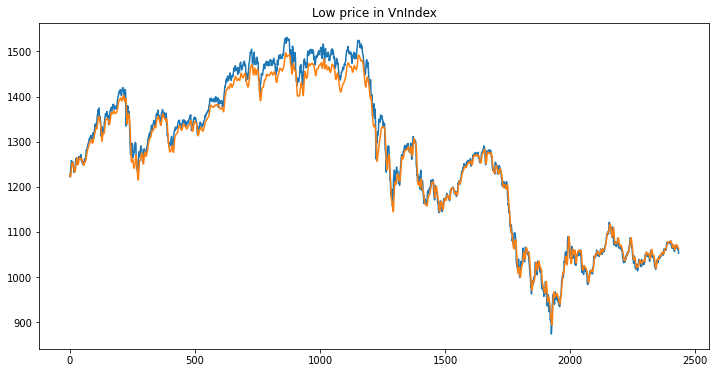

In [37]:
fig = plt.figure(figsize=(12,6))
plt.title('High price in VnIndex')``
plt.plot(y_test_scale[:, 0], label = 'Predicted')
plt.plot(bidir_pred_scale[:, 1], label = 'Our')
plt.savefig(FIG_PATH)

In [34]:
bidir_pred_scale[:, 0] == bidir_pred_scale[:, 1]

array([False, False, False, ..., False, False, False])